![Semillero Astrofisica](../logo.PNG)

---
# Ajuste de Funciones con Estudio de Incertidumbre 


Carlos Andrés del Valle (cdelv@unal.edu.co)

---

Este cuadernillo muestra cómo ajustar una función utilizando **DeepXDE** pero estudiando la **incertidumbre** del ajuste. Además se utiliza una red normal y una **Multi-fidelity Neural Network**. Información sobre estas redes se puede encontrar en 

- https://www.sciencedirect.com/science/article/pii/S0021999119307260?via%3Dihub
- https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.4.023210

EXPLICACIÓN BREVE DE Multi-fidelity Neural Network

In [1]:
import deepxde as dde
import numpy as np

def func(x):
    return x*np.sin(5*x)

def func_lo(x):
    A, B, C = 0.5, 1/5, 2
    return A*x*np.sin(B*5*x)+C


Using backend: tensorflow.compat.v1

2022-10-19 11:04:13.325615: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-10-19 11:04:13.328659: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-19 11:04:13.328672: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Instructions for updating:
non-resource variables are not supported in the long term


2022-10-19 11:04:14.585592: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-19 11:04:14.585625: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pop-os): /proc/driver/nvidia/version does not exist


## 1. Definir la geometría del problema

La geometría del problema se refiere a la regíon en la que se va a entrenar la red neuronal

In [2]:
geom = dde.geometry.Interval(-1, 1)

## 2. Parametros del modelo de entrenamiento

Revisar https://deepxde.readthedocs.io/en/latest/modules/deepxde.data.html?highlight=data.MfFunc#deepxde.data.mf.MfFunc para ver la declaración de **data.MfFunc**.

In [3]:
num_train = 10
num_test = 1000
data1 = dde.data.Function(geom, func, num_train, num_test, train_distribution='uniform', online=False)
data2 = dde.data.MfFunc(geom, func_lo, func, num_train, num_train, num_test, dist_train='uniform')

## 3. Definir la red Neuronal

En este caso estamos utilizando una red normal y una **Multi-fidelity Neural Network**.

~~~python
class deepxde.nn.tensorflow_compat_v1.mfnn.MfNN(layer_sizes_low_fidelity, 
                                                layer_sizes_high_fidelity, 
                                                activation, 
                                                kernel_initializer, 
                                                regularization=None, 
                                                residue=False, 
                                                trainable_low_fidelity=True, 
                                                trainable_high_fidelity=True)
~~~

In [4]:
## Parámetros para las redes
activation = "tanh"
initializer = "Glorot uniform"
regularization = ["l2", 1e-5]
dropout_rate = 0.01

net1 = dde.nn.FNN( #Red Normal
    [1] + [20] * 3 + [1],
    activation,
    initializer,
    regularization=regularization,
    dropout_rate=dropout_rate,
)
net2 = dde.nn.MfNN( #Red Mf
    [1] + [20] * 3 + [1],
    [10] * 1 + [1],
    activation,
    initializer,
    regularization=regularization,
)

## 4. Compilar y entrenar los modelos


In [5]:
uncertainty = dde.callbacks.DropoutUncertainty(period=1000)

model1 = dde.Model(data1, net1)
model1.compile("adam", lr=0.001, metrics=["l2 relative error"])
losshistory1, train_state1 = model1.train(iterations=20000, callbacks=[uncertainty])

Compiling model...
Building feed-forward neural network...
'build' took 0.060377 s

'compile' took 0.188419 s

Initializing variables...


/home/wind/.local/lib/python3.10/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:103: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
/home/wind/.local/lib/python3.10/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:86: UserWarning: `tf.layers.dropout` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dropout` instead.
  y = tf.layers.dropout(y, rate=self.dropout_rate, training=self.training)
2022-10-19 11:04:16.176392: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-19 11:04:16.308068: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] 

Training model...

Step      Train loss              Test loss               Test metric   
0         [2.55e-01, 4.54e-04]    [2.05e-01, 4.54e-04]    [1.01e+00]    
1000      [1.31e-02, 6.83e-04]    [1.38e-02, 6.83e-04]    [2.61e-01]    
2000      [1.64e-03, 7.82e-04]    [2.03e-03, 7.82e-04]    [1.00e-01]    
3000      [3.55e-03, 8.21e-04]    [1.90e-03, 8.21e-04]    [9.68e-02]    
4000      [1.38e-02, 8.64e-04]    [3.15e-03, 8.64e-04]    [1.25e-01]    
5000      [7.16e-03, 9.02e-04]    [1.48e-03, 9.02e-04]    [8.54e-02]    
6000      [7.92e-04, 9.51e-04]    [6.57e-04, 9.51e-04]    [5.70e-02]    
7000      [7.20e-04, 9.89e-04]    [9.75e-04, 9.89e-04]    [6.94e-02]    
8000      [2.98e-03, 1.03e-03]    [2.28e-03, 1.03e-03]    [1.06e-01]    
9000      [3.13e-03, 1.07e-03]    [9.65e-04, 1.07e-03]    [6.90e-02]    
10000     [2.32e-03, 1.09e-03]    [1.24e-03, 1.09e-03]    [7.84e-02]    
11000     [2.48e-04, 1.11e-03]    [8.29e-04, 1.11e-03]    [6.40e-02]    
12000     [4.84e-03, 1.11e-03]  

In [6]:
model2 = dde.Model(data2, net2)
model2.compile("adam", lr=0.001, metrics=["l2 relative error"])
losshistory2, train_state2 = model2.train(iterations=20000)

Compiling model...
Building multifidelity neural network...
'build' took 0.067545 s



/home/wind/.local/lib/python3.10/site-packages/deepxde/nn/tensorflow_compat_v1/mfnn.py:114: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.278015 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric             
0         [4.81e+00, 1.12e+00, 9.25e-04]    [4.54e+00, 8.53e-01, 9.25e-04]    [1.00e+00, 2.11e+00]    
1000      [2.75e-02, 7.14e-02, 6.62e-04]    [7.92e-02, 6.90e-02, 6.62e-04]    [6.77e-02, 5.84e-01]    
2000      [6.39e-03, 4.78e-02, 7.70e-04]    [9.82e-03, 5.16e-02, 7.70e-04]    [3.21e-02, 5.03e-01]    
3000      [3.44e-04, 4.03e-02, 8.12e-04]    [9.64e-04, 4.55e-02, 8.12e-04]    [7.65e-03, 4.72e-01]    
4000      [2.86e-04, 1.81e-02, 9.06e-04]    [9.64e-04, 2.18e-02, 9.06e-04]    [6.34e-03, 3.27e-01]    
5000      [7.70e-05, 3.19e-03, 1.03e-03]    [2.42e-04, 3.83e-03, 1.03e-03]    [3.40e-03, 1.37e-01]    
6000      [3.39e-05, 1.67e-03, 1.05e-03]    [4.39e-05, 2.07e-03, 1.05e-03]    [2.49e-03, 1.01e-01]    
7000      [2.03e-05, 1.54e-03, 1.01e-03]    [2.87e-05, 1.94e-03, 1.01e-03]    [1.95e-03, 9.74e-02]    
8

## 5. Visualizar los resultados

### Fully-connected neural network

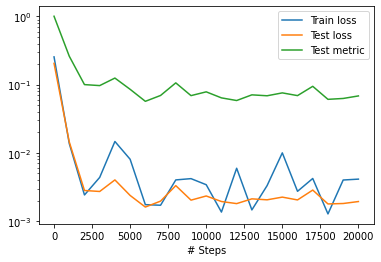

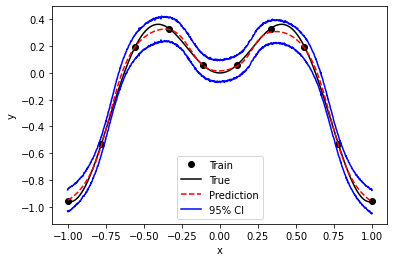

In [7]:
dde.saveplot(losshistory1, train_state1, issave=False, isplot=True)

### Multi-fidelity Neural Network

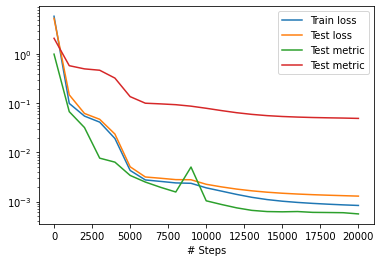

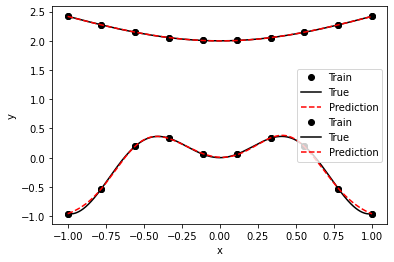

In [8]:
dde.saveplot(losshistory2, train_state2, issave=False, isplot=True)